c:\Users\User\anaconda3\envs\openmmlab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(256, 256, 3)


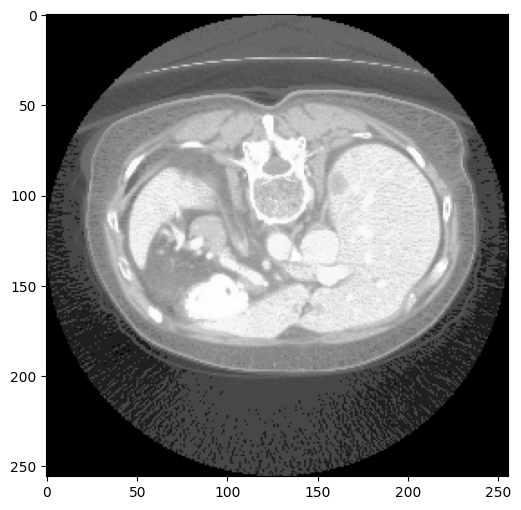

(256, 256, 3)


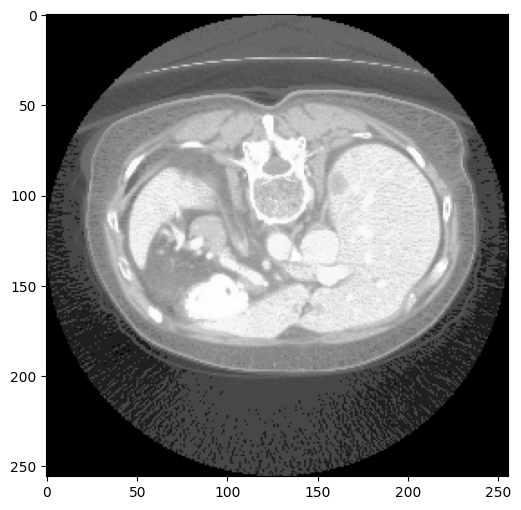

(256, 256, 3)


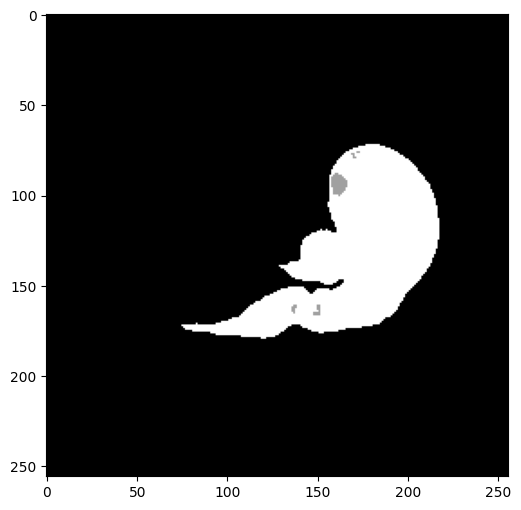

(256, 256, 3)


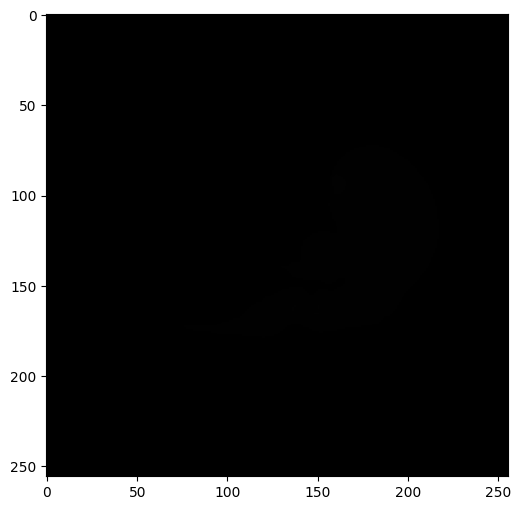

In [2]:
import mmcv
import mmengine
import matplotlib.pyplot as plt

general_path = "H:/justyna/dane"

path_old = general_path + "/volumes_norm/volume-0_58.png" 
path = general_path + "/volumes_norm/volume-0_58.png" 
path_label = general_path + "/volume_labels/volume-0_58.png" 
path_seg = general_path + "/volume_labels/segmentation-0_58.png" 

img = mmcv.imread(path_old)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_seg)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [3]:
data_root = general_path
img_dir = 'volumes_norm'
ann_dir = 'volume_labels'

# define class and palette for better visualization
classes = ('other', 'liver', 'lesion')
palette = [[0, 0, 0], [0, 0, 255], [255, 0, 0]]

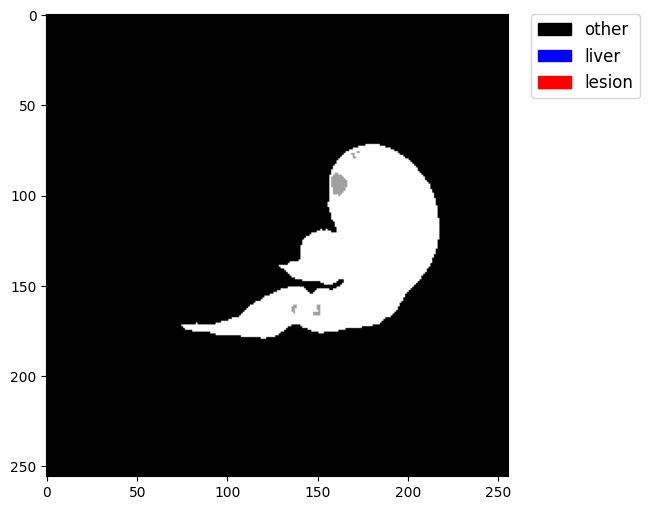

In [4]:
# Let's take a look at the segmentation map we got
import os
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches

img = Image.open(path_label)
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [5]:
# split train/val/test set randomly
# w plikach splits wszystko powinno być zapisane jako volume

split_dir = 'splits'
split_file = 'volume'

mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png') if split_file in filename]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 70/100 as train set
    train_length = int(len(filename_list)*70/100)
    f.writelines(line + '\n' for line in filename_list[:train_length])

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select next 15/100 as val set
    val_length = int(len(filename_list)*85/100)
    f.writelines(line + '\n' for line in filename_list[train_length:val_length])
    
with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
    # select last 15/100 as test set
    f.writelines(line + '\n' for line in filename_list[val_length:])

In [6]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class LiverCancerDataset(BaseSegDataset):
    METAINFO = dict(classes = classes, palette = palette)
    def __init__(self, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [7]:
from mmengine import Config

general_path2 = "C:/Users/User/mmsegmentation/configs/"
# cfg = Config.fromfile(general_path2 + '/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
# cfg = Config.fromfile(general_path2 + '/unet/unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py')
cfg = Config.fromfile(general_path2 + '/resnest/resnest_s101-d8_fcn_4xb2-80k_cityscapes-512x1024.py')


print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=8000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

In [8]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', device='cpu')
cfg.crop_size = (256, 256)
cfg.workers_per_gpu = 0

cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'LiverCancerDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomResize', scale=(256, 256), ratio_range=(1.0, 1.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

# IMPORTANT
cfg.train_dataloader.num_workers = 0
cfg.train_dataloader.persistent_workers = False

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

# IMPORTANT
cfg.val_dataloader.num_workers = 0
cfg.val_dataloader.persistent_workers = False

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = 'splits/test.txt'
cfg.test_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])

# TUTAJ TRZEBA WSTAWIĆ PLIK PATH Z ITERACJI Z KTOREJ CHCEMY WYKORZYSTAC MODEL
cfg.load_from = 'H:/justyna/output/iter_40000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'H:/justyna/output/res_all_results'

# cfg.train_cfg.max_iters = 600
cfg.train_cfg.val_interval = 5000
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'H:/justyna/dane'
dataset_type = 'LiverCancerDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=1000, type='CheckpointHook'),
    logger=dict(interval=100, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

In [9]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/02 21:29:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 1060 6GB
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 1.12.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm

c:\users\user\mmsegmentation\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
c:\users\user\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\users\user\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/02 21:29:54 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/02 21:29:54 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

c:\users\user\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [10]:
# start training
runner.test()

04/02 21:29:55 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: H:/justyna/output/iter_40000.pth
04/02 21:29:55 - mmengine - INFO - Load checkpoint from H:/justyna/output/iter_40000.pth
04/02 21:30:06 - mmengine - INFO - Iter(test) [ 100/8796]    eta: 0:14:54  time: 0.0663  data_time: 0.0017  memory: 2476  
04/02 21:30:12 - mmengine - INFO - Iter(test) [ 200/8796]    eta: 0:12:08  time: 0.0666  data_time: 0.0019  memory: 437  
04/02 21:30:19 - mmengine - INFO - Iter(test) [ 300/8796]    eta: 0:11:09  time: 0.0668  data_time: 0.0019  memory: 437  
04/02 21:30:26 - mmengine - INFO - Iter(test) [ 400/8796]    eta: 0:10:36  time: 0.0666  data_time: 0.0019  memory: 437  
04/02 21:30:32 - mmengine - INFO - Iter(test) [ 500/8796]    eta: 0:10:14  time: 0.0670  data_time: 0.0020  memory: 437  
04/02 21:30:39 - mmengine - INFO - Iter(test) [ 600/8796]    eta: 0:09:57  time: 0.0662  data_time: 0.0019  memory: 437  
04/02 21:30:4

{'aAcc': 99.69,
 'mIoU': 77.99,
 'mAcc': 82.8,
 'mDice': 85.84,
 'mFscore': 85.84,
 'mPrecision': 90.32,
 'mRecall': 82.8}

In [11]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = 'H:/justyna/dane/output/iter_40000.pth'

model = init_model(cfg, checkpoint_path, 'cuda:0')


general_path = "H:/justyna/dane"

path_old = general_path + "/volumes_norm/volume-0_58.png" 
path = general_path + "volumes_norm/volume-0_58.png" 
path_label = general_path + "/volume_labels/volume-0_58.png" 
path_seg = general_path + "/volume_labels/segmentation-0_58.png" 

img = mmcv.imread(path)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(vis_result)


img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_old)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(vis_result)


img = mmcv.imread(path_old)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

path = general_path + "/volumes_norm/volume-92_466.png" 
path_label = general_path + "/volume_labels/volume-92_466.png" 

img = mmcv.imread(path)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result, with_labels=True)
plt.imshow(vis_result)


img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Loads checkpoint by local backend from path: H:/justyna/dane/output/iter_40000.pth


FileNotFoundError: H:/justyna/dane/output/iter_40000.pth can not be found.